In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from random import choices, sample

In [2]:
from os import listdir
from os.path import isfile, isdir, join

# 指定要列出所有檔案的目錄
mypath = './weblog_sorted'
# 取得所有檔案與子目錄名稱
files = listdir(mypath)
csv_list = []
# 以迴圈處理
for f in files:
  # 產生檔案的絕對路徑
  fullpath = join(mypath, f)
  # 判斷 fullpath 是檔案還是目錄
  if isfile(fullpath):
#     print("檔案：", f)
    if f[-4:]=='.csv':
        csv_list.append(f)
csv_list.sort()

In [3]:
def negative_sampling(samples, num_of_samples):
    from collections import Counter
    ctr = Counter(samples)
    dict_ctr_freq = {}
    for i in ctr:
        dict_ctr_freq[i] = ctr[i] / len(samples)
    numerator = { pid: freq ** 0.75 for pid, freq in dict_ctr_freq.items()}
    denominator = sum(numerator.values())
    prob = { pid: freq_f/denominator for pid, freq_f in numerator.items()}
    from random import choices
    return choices(list(prob.keys()), weights=list(prob.values()),k=num_of_samples)

In [4]:
def freq_sampling(samples, num_of_samples):
    from collections import Counter
    ctr = Counter(samples)
    dict_ctr_freq = {}
    for i in ctr:
        dict_ctr_freq[i] = ctr[i] / len(samples)
    from random import choices
    return choices(list(dict_ctr_freq.keys()), weights=list(dict_ctr_freq.values()),k=num_of_samples)

---

In [5]:
with open('./item_data/en_behavior_emb.pkl', 'rb') as file:
    emb = pickle.load(file)

In [6]:
pid_pairs_all = []
for date in tqdm(csv_list[:14]):
    with open('./pid_pairs/pid_pairs_' + date[:-4] + '.pkl', 'rb') as file:
        pid_pairs_all += pickle.load(file)
print(len(pid_pairs_all))

100%|██████████| 14/14 [00:00<00:00, 59.76it/s]

1434877


In [7]:
pid_pairs_all = []
for date in tqdm(csv_list):
    with open('./pid_pairs/pid_pairs_' + date[:-4] + '.pkl', 'rb') as file:
        pid_pairs_all += pickle.load(file)

100%|██████████| 122/122 [00:02<00:00, 55.59it/s]


In [8]:
len(pid_pairs_all)

13836074

In [9]:
1434877 / len(pid_pairs_all)

0.10370550200873456

In [10]:
target, _next = zip(*pid_pairs_all[:1434877])

In [11]:
len(target)

1434877

In [12]:
SAMPLE_SIZE = 1434877

In [13]:
# positive_pairs = freq_sampling(iid_pairs, SAMPLE_SIZE)

In [14]:
positive_pairs = pid_pairs_all[:1434877]

In [15]:
# negative_pairs = list(zip(freq_sampling(target, SAMPLE_SIZE), negative_sampling(_next, SAMPLE_SIZE)))
negative_pairs = list(zip(target, negative_sampling(_next, SAMPLE_SIZE)))

In [16]:
def yield_can_found_pair_emb(pairs): # drop_not_found
    for pair in tqdm(pairs):
        if pair[0] in emb and pair[1] in emb:
            yield (emb[pair[0]], emb[pair[1]])

In [17]:
positive_training_data = [np.hstack(pair) for pair in yield_can_found_pair_emb(positive_pairs)]
negative_training_data = [np.hstack(pair) for pair in yield_can_found_pair_emb(negative_pairs)]
positive_sample_size = len(positive_training_data)
negative_sample_size = len(negative_training_data)
training_data_sample = np.vstack((positive_training_data, negative_training_data))

100%|██████████| 1434877/1434877 [00:05<00:00, 267646.48it/s]


In [18]:
type(training_data_sample)

numpy.ndarray

In [19]:
training_data_sample.shape

(2274919, 256)

In [20]:
(positive_sample_size, negative_sample_size)

(1192351, 1082568)

In [21]:
ones = np.ones((positive_sample_size, 1))
zeros = np.zeros((negative_sample_size, 1))
label = np.vstack((ones, zeros))

In [22]:
label.shape

(2274919, 1)

---

In [23]:
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, losses, metrics, callbacks

Using TensorFlow backend.


In [24]:
X_train, y_train = training_data_sample, label

In [25]:
model = models.Sequential()
model.add(layers.Dense(512, activation='linear', input_shape=(256,)))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(256, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(128, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(64, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.mse])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [28]:
# checkpoint
filepath = './saved_model/' + str(SAMPLE_SIZE) + '_' + time.strftime("%m%d", time.localtime()) + ".h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [29]:
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=.35,
                    verbose=1,
                    callbacks=callbacks_list)

Train on 1478697 samples, validate on 796222 samples
Epoch 1/30
1478697/1478697 [==============================] - 36s 24us/step - loss: 0.1834 - mean_squared_error: 0.0555 - val_loss: 0.7138 - val_mean_squared_error: 0.2170

Epoch 00001: val_loss improved from inf to 0.71378, saving model to ./saved_model/1434877_0424.h5
Epoch 2/30
1478697/1478697 [==============================] - 35s 24us/step - loss: 0.1588 - mean_squared_error: 0.0479 - val_loss: 0.5486 - val_mean_squared_error: 0.1720

Epoch 00002: val_loss improved from 0.71378 to 0.54864, saving model to ./saved_model/1434877_0424.h5
Epoch 3/30
1478697/1478697 [==============================] - 36s 24us/step - loss: 0.1520 - mean_squared_error: 0.0457 - val_loss: 0.5547 - val_mean_squared_error: 0.1683

Epoch 00003: val_loss did not improve from 0.54864
Epoch 4/30
1478697/1478697 [==============================] - 35s 24us/step - loss: 0.1478 - mean_squared_error: 0.0443 - val_loss: 0.5710 - val_mean_squared_error: 0.1703

Epoc

In [30]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

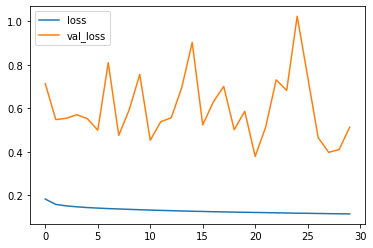

In [31]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

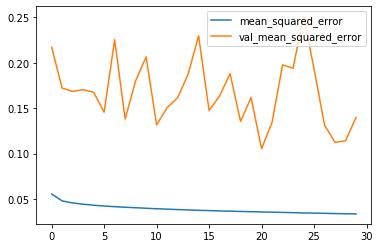

In [32]:
pd.DataFrame(history.history)[['mean_squared_error', 'val_mean_squared_error']].plot()